<a href="https://colab.research.google.com/github/oscarserc/TESIS_Transformers/blob/main/2b_Practica_MULTIHEAD_Attencion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 526 kB 5.5 MB/s 
     |████████████████████████████████| 132 kB 45.1 MB/s 
     |████████████████████████████████| 596 kB 60.8 MB/s 
     |████████████████████████████████| 829 kB 39.9 MB/s 
     |████████████████████████████████| 332 kB 39.4 MB/s 
     |████████████████████████████████| 1.1 MB 40.8 MB/s 
     |████████████████████████████████| 160 kB 46.2 MB/s 
     |████████████████████████████████| 192 kB 45.7 MB/s 
     |████████████████████████████████| 271 kB 60.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=4828441b4e133d16e65ffc154e73b663a3d080dff1fcbd9a5718de9dce445528
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [ ]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader


In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X.iloc[ix]).float(), torch.tensor(self.y.iloc[ix]).long()

# ================================
# MÓDULO PARA ITERAR POR LOS DATOS
# ================================

class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, batch_size: int=64, Dataset=Dataset):
    super().__init__()
    self.batch_size = batch_size
    self.Dataset = Dataset

  def setup(self, stage=None):
    mnist = fetch_openml('mnist_784', version=1)
    X, y  = mnist['data'], mnist['target']
    X_train, X_test = X[:60000]/255., X[60000:]/255.
    y_train, y_test = y[:60000].astype(np.int), y[60000:].astype(np.int)
    # Referenciamos a la clase para que nos construya los TENSORES
    self.train_ds = self.Dataset(X_train, y_train)
    self.val_ds   = self.Dataset(X_test, y_test)

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size)    


In [ ]:
dm_mnist = MNISTDataModule()
dm_mnist.setup()

imgs, labels = next(iter(dm_mnist.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 784]), torch.Size([64]))

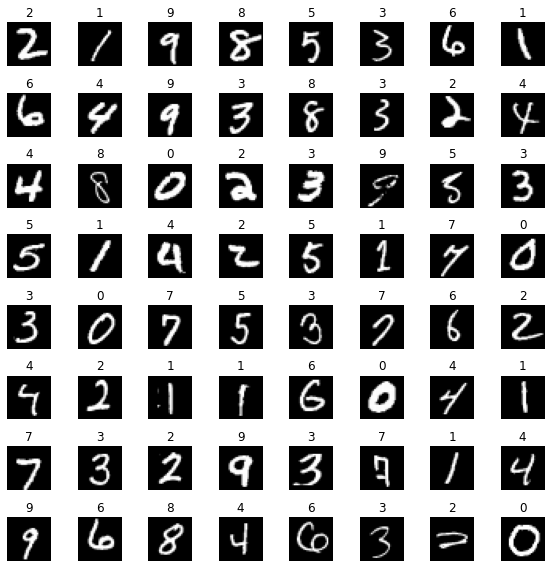

In [ ]:

r, c = 8, 8
fig = plt.figure(figsize=(r,c))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(label.item())
plt.tight_layout()
plt.show()    


In [ ]:

# =====================
# MÓDULO PARA EL MODELO
# =====================

class MLP(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(784, 784),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(784, 10)
    )

  def forward(self, X):
    return self.mlp(X)

  def predict(self, X):
    with torch.no_grad():
      y_hat = self(X)  
      return torch.argmax(y_hat, axis=1)

  def compute_loss_and_acc(self, batch):
    x, y = batch
    y_hat = self(x)
    loss  = F.cross_entropy(y_hat, y)
    acc   = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('loss', loss)
    self.log('acc', acc, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('val_loss', loss, prog_bar=True)
    self.log('val_acc' , acc, prog_bar=True)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
    return optimizer           


In [ ]:
modelo_mlp = MLP()
salidas = modelo_mlp(torch.randn(64, 784))
salidas.shape

torch.Size([64, 10])

In [ ]:
modelo_mlp = MLP()
trainer = pl.Trainer(max_epochs=2, gpus=0, logger=None)
trainer.fit(modelo_mlp, dm_mnist)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


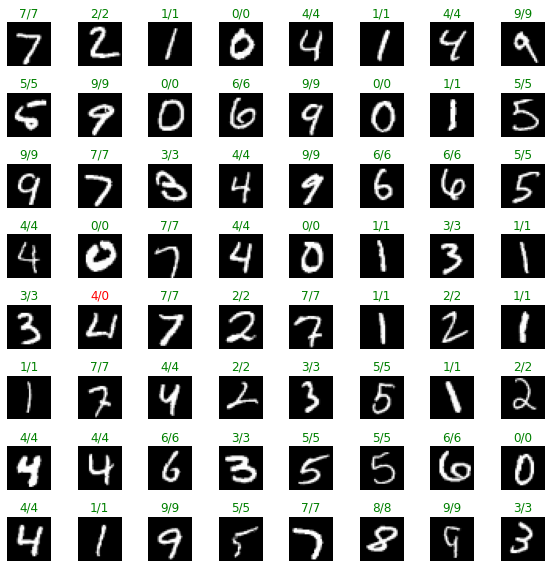

In [ ]:
imgs, labels = next(iter(dm_mnist.val_dataloader()))
predicciones = modelo_mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(r,c))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(f'{label.item()}/{predicciones[ix].item()}', color='green' if label == predicciones[ix] else 'red')
plt.tight_layout()
plt.show()    


# **AHORA RESOLVEMOS EL PROBLEMA EMPLEANDO UN MECANISMO DE ATENCIÓN**

In [ ]:
class AttnDataset(pl.LightningDataModule):
  def __init__(self, X, y, patch_size=(7,7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X.iloc[ix]).float().view(28,28)
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w)
    patches = patches.contiguous().view(-1, h*w)
    return patches, torch.tensor(self.y.iloc[ix]).long()


In [ ]:
attn_dm = MNISTDataModule(Dataset=AttnDataset)
attn_dm.setup()

imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 16, 49]), torch.Size([64]))

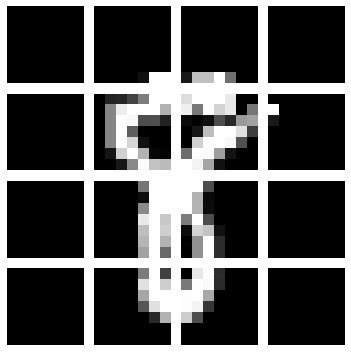

In [ ]:

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
  for j in range(4):
    ax = plt.subplot(4, 4, i*4 + j + 1)
    ax.imshow(imgs[5, i*4 + j].view(7,7), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()    


In [ ]:
import math

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, n_embd, n_heads):
    super().__init__()
    self.n_heads = n_heads

    # KEY, QUERY, VALUE
    self.key   = torch.nn.Linear(n_embd, n_embd*n_heads)
    self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
    self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

    # proyección salida
    self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

  def forward(self, x):
    B, L, F = x.size()

    # Calcular las query, key y values en TODAS LAS CABEZAS
    k = self.key(x).view(B, L, F, self.n_heads).transpose(1,3)
    q = self.query(x).view(B, L, F, self.n_heads).transpose(1,3)
    v = self.value(x).view(B, L, F, self.n_heads).transpose(1,3)

    # Mecanismo de atencion
    att = (q @ k.transpose(-2, -1))*(1.0 / math.sqrt(k.size(-1)))
    att = torch.nn.functional.softmax(att, dim=-1)
    y = att @ v
    y = y.transpose(1,2).contiguous().view(B, L, F*self.n_heads)

    return self.proj(y) 


class Model(MLP):
  def __init__(self, n_embd=7*7, seq_len=4*4, n_heads=4*4):
    super().__init__()
    self.mlp = None

    self.attn = MultiHeadAttention(n_embd, n_heads)
    self.actn = torch.nn.ReLU(inplace=True)
    self.fc   = torch.nn.Linear(n_embd*seq_len, 10)

  def forward(self, x):
    x = self.attn(x)
    y = self.fc(self.actn(x.view(x.size(0), -1)))
    return y  


In [ ]:
modelo_attn = Model()
trainer = pl.Trainer(max_epochs=2, gpus=0, logger=None)
trainer.fit(modelo_attn, attn_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type               | Params
--------------------------------------------
0 | attn | MultiHeadAttention | 156 K 
1 | actn | ReLU               | 0     
2 | fc   | Linear             | 7.9 K 
--------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.656     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_z

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

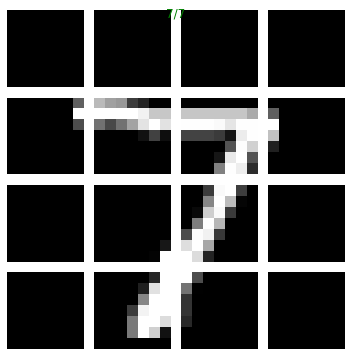

In [ ]:
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
predicciones = modelo_attn.predict(attn_imgs)

ix = random.randint(0,attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
  for j in range(4):
    ax = plt.subplot(4, 4, i*4 + j + 1)
    ax.imshow(attn_imgs[ix,i*4 + j].view(7,7), cmap='gray')
    ax.axis('off')
fig.suptitle(f'{attn_labels[ix]}/{predicciones[ix].item()}', color='green' if attn_labels[ix] == predicciones[ix].item() else 'red')
plt.tight_layout()
plt.show()    
